# Denoising Diffusion Probabilistic Model (DDPM) 
  
Welcome to this Jupyter Notebook titled "Train Denoising Diffusion Probabilistic Model (DDPM) directly on the time series". In this document, I will guide you through the process of training the DDPM on an energy time series. This time series represents energy consumption data measured by CKW smart meters, which is available as open data. The primary objective of this notebook is to illustrate how to use the DDPM for generating synthetic time series data, especially in the context of energy consumption. 

## Data

In [1]:
from torch.utils.data import DataLoader
from utils.data_handler import load_sm_data, DataSet

dataset = DataSet(load_sm_data())  
dataloader = DataLoader(dataset, batch_size = 32, drop_last = True)
next_batch = next(iter(dataloader))
print(next_batch.shape)

torch.Size([32, 96, 1])


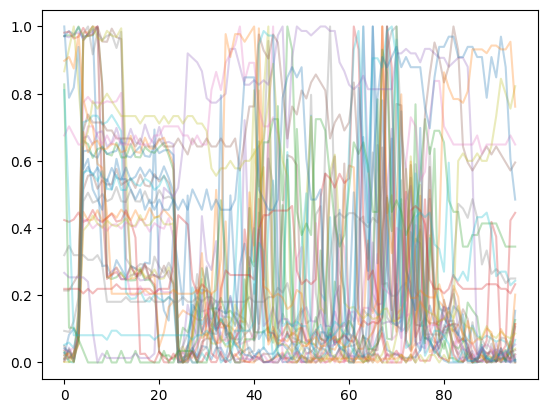

In [2]:
from utils.visualization import plot_next_batch

plot_next_batch(next_batch)

## Schedule

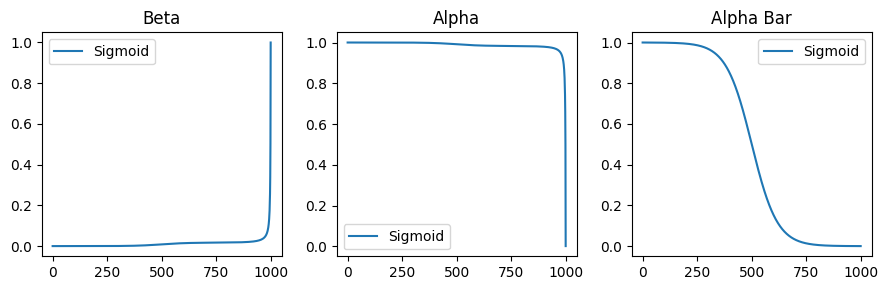

In [3]:
from diffusion_models.noise_schedulers import personalized_noise_schedule, sigmoid_noiseschedule
from utils.visualization import plot_schedule

T=1000

ns = "Sigmoid"
beta_t, alpha_t, alphabar_t = sigmoid_noiseschedule(T, start=-6, end=6, tau=0.7, clip_min=1e-9)

plot_schedule(beta_t, alpha_t, alphabar_t, approach=ns)

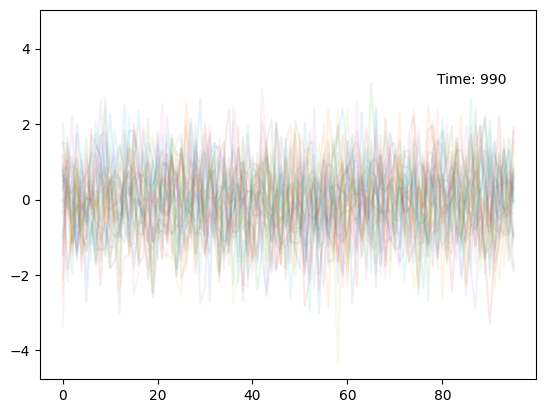

In [4]:
from celluloid import Camera    
import matplotlib.pyplot as plt
import numpy as np

def q_xt(x0, t, alpha_bars):
        mu = x0 * np.sqrt(alpha_bars[t])
        sigma = 1 - alpha_bars[t]
        return mu + sigma * np.random.randn(*x0.shape)


fig, ax = plt.subplots()  
camera = Camera(fig)  
for t in range(0, T, 10):
    for sample in range(next_batch.shape[0]):
        time_sample_t = q_xt(next_batch[sample], t, alphabar_t)
        ax.plot(time_sample_t, alpha=0.1)  
    
    # Add text showing frequency  
    text = ax.text(0.8, 0.8, f'Time: {t}', transform=ax.transAxes) 
    camera.snap()  

    
animation = camera.animate()  

# Save as GIF  
animation.save(f'./outputs/evolution_{ns}_{T}-T.gif', writer='pillow')  

plt.show()  


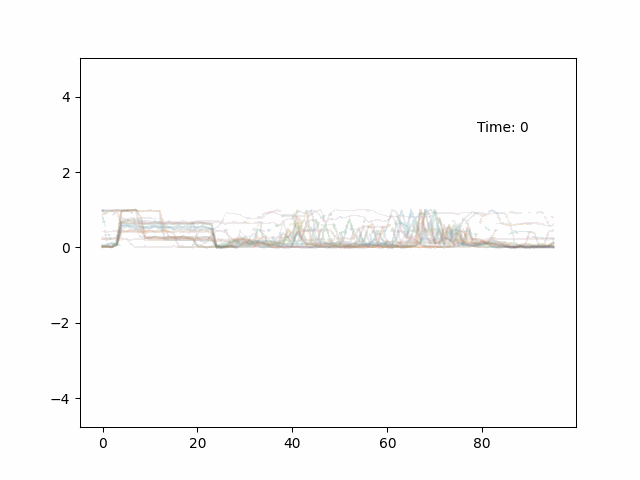

In [5]:
  
from IPython.display import Image  
Image(filename=f'./outputs/evolution_{ns}_{T}-T.gif')  


## Available deep learning architecture for denoising the diffusion

In [6]:
from diffusion_models.denoising_models import dl_models

#denoiser = dl_models.Transformer(n_steps=96, input_dim=1, T=100, hidden_dim=2**9, nhead=2**4, num_layers=3)

denoiser = dl_models.LSTM(n_steps=96, input_dim=1, T=T, hidden_dim=2**9, num_layers=3)

The LSTM created has 68936193 trainable parameters


## Train

In [7]:
import torch
from diffusion_models import Model
from diffusion_models.noise_schedulers import Scheduler

device = torch.device('cuda') if torch.cuda.is_available() else "cpu"

noise_schedule = Scheduler(device, beta_t, alpha_t, alphabar_t)

norm=True

ddpm = Model(
    device=device,
    noise_schedule=noise_schedule,
    dl_architecture=denoiser,
    normalized=norm
)

In [ ]:
import os
import tensorflow as tf
from torch.utils import tensorboard
from tqdm.notebook import tqdm
from diffusion_models.losses import unweighted_mse


# Set parameters for training
epochs = 100000
epoch_iterator = tqdm(range(epochs), desc="Epoch Loop")
step = 0
ckpt = 0

# Set optimizer
optim = torch.optim.Adam(ddpm.parameters(), lr = 0.0001)

# Set tensorboard
tb_dir = f"./outputs/tensorboard/{denoiser.name}/{denoiser.num_layers}-l/{denoiser.hdim}-hd/{T}-T/norm-{norm}/schedule-{ns}"
tf.io.gfile.makedirs(tb_dir)
writer = tensorboard.SummaryWriter(tb_dir)

# Set checkpoint folder to save the model
checkpoint_dir = f"./outputs/checkpoints/{denoiser.name}/{denoiser.num_layers}-l/{denoiser.hdim}-hd/{T}-T/norm-{norm}/schedul-{ns}"
tf.io.gfile.makedirs(checkpoint_dir)
ckpt_dir = os.path.join(checkpoint_dir, f"checkpoint_{ckpt}.pth")

mean_loss = 1.
for epoch in epoch_iterator:
    dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)
    data_iterator = tqdm(dataloader, desc="Steps", leave=False)
    for data in data_iterator:
        data = data.to(device = device)
        noise_prediction, epsilon = ddpm(data, get_target=True)
        loss = unweighted_mse(noise_prediction, epsilon)
        
        optim.zero_grad()
        loss.backward(retain_graph=True)

        # `clip_value` is the upper limit for the gradient.  
        # This line does the actual clipping of gradients.  
        torch.nn.utils.clip_grad_norm_(ddpm.parameters(), 1)  
  
        # Proceed with the optimization step 
        optim.step()
        
        step += 1
        data_iterator.set_postfix(loss=float(loss.detach().cpu()))
        if step > 1:
            mean_loss = (float(loss.detach().cpu()) + (mean_loss * (step -1)))/(step)
        else:
            mean_loss = float(loss.detach().cpu())
        epoch_iterator.set_postfix(loss=mean_loss)
        if step % 50 == 0:
            writer.add_scalar("training loss", loss, step)
            writer.add_scalar("training mean loss", mean_loss, step)


    if (epoch+1) % 1000 == 0:
        # Save the checkpoint.
        save_step = (epoch+1) // 1000
        save_step += ckpt
        torch.save(ddpm.denoiser, os.path.join(checkpoint_dir, f'checkpoint_{save_step}.pth'))
            
torch.save(ddpm.denoiser, os.path.join(checkpoint_dir, f'final_checkpoint.pth'))

2024-04-30 14:04:05.755599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch Loop:   0%|          | 0/100000 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

Steps:   0%|          | 0/62 [00:00<?, ?it/s]

## Test

In [ ]:
import torch